In [95]:
import torch
import torch as th
import torch.nn as nn
from torch import Tensor

import copy
import random
import numpy as np
import matplotlib as mpl
import compress_pickle as cpkl

import rsatoolbox

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # TODO: move to the top

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from ss_baselines.common.utils import plot_top_down_map

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [2]:
# Notebook support or argpase
import sys; sys.argv=['']; del sys

# General config related
from configurator import get_arg_dict, generate_args

# Env config related
from ss_baselines.av_nav.config import get_config
from ss_baselines.savi.config.default import get_config as get_savi_config
from ss_baselines.common.env_utils import construct_envs
from ss_baselines.common.environments import get_env_class

# region: Generating additional hyparams
CUSTOM_ARGS = [
    # General hyper parameters
    get_arg_dict("seed", int, 111),
    get_arg_dict("total-steps", int, 1_000_000),

    # SS env config
    get_arg_dict("config-path", str, "env_configs/audiogoal_rgb_nocont.yaml"),

    # PPO Hyper parameters
    get_arg_dict("num-envs", int, 1), # Number of parallel envs. 10 by default
    get_arg_dict("num-steps", int, 150), # For each env, how many steps are collected to form PPO Agent rollout.
    get_arg_dict("num-minibatches", int, 1), # Number of mini-batches the rollout data is split into to make the updates
    get_arg_dict("update-epochs", int, 4), # Number of gradient step for the policy and value networks
    get_arg_dict("gamma", float, 0.99),
    get_arg_dict("gae-lambda", float, 0.95),
    get_arg_dict("norm-adv", bool, True, metatype="bool"),
    get_arg_dict("clip-coef", float, 0.1), # Surrogate loss clipping coefficient
    get_arg_dict("clip-vloss", bool, True, metatype="bool"),
    get_arg_dict("ent-coef", float, 0.2), # Entropy loss coef; 0.2 in SS baselines
    get_arg_dict("vf-coef", float, 0.5), # Value loss coefficient
    get_arg_dict("max-grad-norm", float, 0.5),
    get_arg_dict("target-kl", float, None),
    get_arg_dict("lr", float, 2.5e-4), # Learning rate
    get_arg_dict("optim-wd", float, 0), # weight decay for adam optim
    ## Agent network params
    get_arg_dict("agent-type", str, "ss-default", metatype="choice",
        choices=["ss-default", "deep-etho",
                    "perceiver-gwt-gwwm", "perceiver-gwt-attgru"]),
    get_arg_dict("hidden-size", int, 512), # Size of the visual / audio features and RNN hidden states 
    ## Perceiver / PerceiverIO params: TODO: num_latnets, latent_dim, etc...
    get_arg_dict("pgwt-latent-type", str, "randn", metatype="choice",
        choices=["randn", "zeros"]), # Depth of the Perceiver
    get_arg_dict("pgwt-latent-learned", bool, True, metatype="bool"),
    get_arg_dict("pgwt-depth", int, 1), # Depth of the Perceiver
    get_arg_dict("pgwt-num-latents", int, 8),
    get_arg_dict("pgwt-latent-dim", int, 64),
    get_arg_dict("pgwt-cross-heads", int, 1),
    get_arg_dict("pgwt-latent-heads", int, 4),
    get_arg_dict("pgwt-cross-dim-head", int, 64),
    get_arg_dict("pgwt-latent-dim-head", int, 64),
    get_arg_dict("pgwt-weight-tie-layers", bool, False, metatype="bool"),
    get_arg_dict("pgwt-ff", bool, False, metatype="bool"),
    get_arg_dict("pgwt-num-freq-bands", int, 6),
    get_arg_dict("pgwt-max-freq", int, 10.),
    get_arg_dict("pgwt-use-sa", bool, False, metatype="bool"),
    ## Peceiver Modality Embedding related
    get_arg_dict("pgwt-mod-embed", int, 0), # Learnable modality embeddings
    ## Additional modalities
    get_arg_dict("pgwt-ca-prev-latents", bool, True, metatype="bool"), # if True, passes the prev latent to CA as KV input data

    # Logging params
    # NOTE: While supported, video logging is expensive because the RGB generation in the
    # envs hogs a lot of GPU, especially with multiple envs 
    get_arg_dict("save-videos", bool, False, metatype="bool"),
    get_arg_dict("save-model", bool, True, metatype="bool"),
    get_arg_dict("log-sampling-stats-every", int, int(1.5e3)), # Every X frames || steps sampled
    get_arg_dict("log-training-stats-every", int, int(10)), # Every X model update
    get_arg_dict("logdir-prefix", str, "./logs/") # Overrides the default one
]
args = generate_args(CUSTOM_ARGS)

# Additional PPO overrides
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.num_minibatches)

# Load environment config
is_SAVi = str.__contains__(args.config_path, "savi")
if is_SAVi:
    env_config = get_savi_config(config_paths=args.config_path)
else:
    env_config = get_config(config_paths=args.config_path)
# endregion: Generating additional hyparams

In [3]:
# Overriding some envs parametes from the .yaml env config
env_config.defrost()
env_config.NUM_PROCESSES = 1 # Corresponds to number of envs, makes script startup faster for debugs
env_config.USE_SYNC_VECENV = True
# env_config.USE_VECENV = False
# env_config.CONTINUOUS = args.env_continuous
## In caes video saving is enabled, make sure there is also the rgb videos
env_config.freeze()
# print(env_config)

# Environment instantiation
# envs = construct_envs(env_config, get_env_class(env_config.ENV_NAME))
# Dummy environment spaces
from gym import spaces
single_action_space = spaces.Discrete(4)
single_observation_space = spaces.Dict({
    "rgb": spaces.Box(shape=[128,128,3], low=0, high=255, dtype=np.uint8),
    "depth": spaces.Box(shape=[128,128,1], low=0, high=255, dtype=np.uint8),
    "audiogoal": spaces.Box(shape=[2,16000], low=-3.4028235e+38, high=3.4028235e+38, dtype=np.float32),
    "spectrogram": spaces.Box(shape=[65,26,2], low=-3.4028235e+38, high=3.4028235e+38, dtype=np.float32)
})
# single_observation_space = envs.observation_spaces[0]
# single_action_space = envs.action_spaces[0]

single_observation_space, single_action_space

(Dict(audiogoal:Box(-3.4028235e+38, 3.4028235e+38, (2, 16000), float32), depth:Box(0, 255, (128, 128, 1), uint8), rgb:Box(0, 255, (128, 128, 3), uint8), spectrogram:Box(-3.4028235e+38, 3.4028235e+38, (65, 26, 2), float32)),
 Discrete(4))

# Loading the Category-Scene-Trajs file

In [4]:
# Specify file name
analysis_trajs_filename = "cats_scenes_trajs_C_6_M_5_N_5__2023_06_01_10_41.bz2"

# Read the filtred trajectories data
## Default format is {cat -> { scenes -> traj: []}}
with open(analysis_trajs_filename, "rb") as f:
    cats_scenes_trajs_dict = cpkl.load(f)

In [5]:
for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    print(f"Cat: {catname}; Scenes: {[k for k in cat_scenes_trajs.keys()]}")

Cat: chair; Scenes: ['gTV8FGcVJC9', 'b8cTxDM8gDG', 'D7N2EKCX4Sj', 'Vvot9Ly1tCj', 'vyrNrziPKCB']
Cat: picture; Scenes: ['gTV8FGcVJC9', 'D7N2EKCX4Sj', 'vyrNrziPKCB', 'Vvot9Ly1tCj', 'b8cTxDM8gDG']
Cat: table; Scenes: ['vyrNrziPKCB', 'b8cTxDM8gDG', 'D7N2EKCX4Sj', 'Vvot9Ly1tCj', 'gTV8FGcVJC9']
Cat: cushion; Scenes: ['b8cTxDM8gDG', 'Vvot9Ly1tCj', 'vyrNrziPKCB', 'gTV8FGcVJC9', 'D7N2EKCX4Sj']
Cat: cabinet; Scenes: ['gTV8FGcVJC9', 'vyrNrziPKCB', 'b8cTxDM8gDG', 'Vvot9Ly1tCj', 'D7N2EKCX4Sj']
Cat: plant; Scenes: ['gTV8FGcVJC9', 'Vvot9Ly1tCj', 'b8cTxDM8gDG', 'vyrNrziPKCB', 'D7N2EKCX4Sj']


In [6]:
## Compute the equivalent scenes cat trajs format
## {scenes -> { cat -> trajs: []}}
scenes_cats_trajs_dict = {}
for cat, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    for scene, scenes_trajs in cat_scenes_trajs.items():
        if scene not in scenes_cats_trajs_dict.keys():
            scenes_cats_trajs_dict[scene] = {}
        
        scenes_cats_trajs_dict[scene][cat] = scenes_trajs

In [7]:
for scene, scenes_cat_trajs in scenes_cats_trajs_dict.items():
    print(f"Scene: {scene}; Cats: {[k for k in scenes_cat_trajs.keys()]}")

Scene: gTV8FGcVJC9; Cats: ['chair', 'picture', 'table', 'cushion', 'cabinet', 'plant']
Scene: b8cTxDM8gDG; Cats: ['chair', 'picture', 'table', 'cushion', 'cabinet', 'plant']
Scene: D7N2EKCX4Sj; Cats: ['chair', 'picture', 'table', 'cushion', 'cabinet', 'plant']
Scene: Vvot9Ly1tCj; Cats: ['chair', 'picture', 'table', 'cushion', 'cabinet', 'plant']
Scene: vyrNrziPKCB; Cats: ['chair', 'picture', 'table', 'cushion', 'cabinet', 'plant']


## A few functions to extract trajectory data based on "category" and "scene"

In [ ]:
# All trajs for the same category, for all the scenes in the subset
def get_catname__rgb_obs_list_flat(cats_scenes_trajs_dict, catname):
    rgb_obs_list = []
    for scene in list(cats_scenes_trajs_dict[catname].keys()):
        for cat_scene_traj_dict in cats_scenes_trajs_dict[catname][scene]:
            edd = cat_scene_traj_dict["edd"]
            for rgb_obs in edd["obs_list"]["rgb"]:
                rgb_obs_list.append(rgb_obs)
    
    return np.array(rgb_obs_list).reshape(len(rgb_obs_list), -1)

def get_catname__info_top_down_map_img_flat(cats_scenes_trajs_dict, catname):
    info_top_down_map_img_list = []
    for scene in list(cats_scenes_trajs_dict[catname].keys()):
        for cat_scene_traj_dict in cats_scenes_trajs_dict[catname][scene]:
            edd = cat_scene_traj_dict["edd"]
            for info_dict in edd["info_list"]:
                # NOTE: when plotting the top down map in a pretty way, dimensions
                # will vary from one scene to another, so not possible to reduce it
                top_down_map_img = plot_top_down_map(info_dict)
                info_top_down_map_img_list.append(top_down_map_img)

                # The follwing uses the "raw" top_down_map, which hopefully 
                # is invariant dimension-wise.
                # top_down_map_img = info_dict["top_down_map"]["map"]
                # info_top_down_map_img_list.append(top_down_map_img)
    
    return np.array(info_top_down_map_img_list).reshape(len(info_top_down_map_img_list), -1)


# All trajs for the same category and same room
def get_catname_scene__rgb_obs_list_flat(cats_scenes_trajs_dict, catname, scene_id):
    rgb_obs_list = []
    for cat_scene_traj_dict in cats_scenes_trajs_dict[catname][scene_id]:
        edd = cat_scene_traj_dict["edd"]
        for rgb_obs in edd["obs_list"]["rgb"]:
            rgb_obs_list.append(rgb_obs)
    
    return np.array(rgb_obs_list).reshape(len(rgb_obs_list), -1)

# --- Scenes -> Cats -> Trajs variantscats_scenes_trajs_dict
def get_scene__rgb_obs_list_flat(scenes_cats_trajs_dict, scene):
    rgb_obs_list = []
    for cat in list(scenes_cats_trajs_dict[scene].keys()):
        for scene_cat_traj_dict in scenes_cats_trajs_dict[scene][cat]:
            edd = scene_cat_traj_dict["edd"]
            for rgb_obs in edd["obs_list"]["rgb"]:
                rgb_obs_list.append(rgb_obs)
    
    return np.array(rgb_obs_list).reshape(len(rgb_obs_list), -1)

def get_scene_last_N__rgb_obs_list_flat(scenes_cats_trajs_dict, scene, N=5):
    # This one only collects the last 5 frames of the trajectory
    rgb_obs_list = []
    for cat in list(scenes_cats_trajs_dict[scene].keys()):
        for scene_cat_traj_dict in scenes_cats_trajs_dict[scene][cat]:
            edd = scene_cat_traj_dict["edd"]
            rgb_obs_list.extend(edd["obs_list"]["rgb"][-N:])
    
    return np.array(rgb_obs_list).reshape(len(rgb_obs_list), -1)

def get_scene_cat__rgb_obs_list_flat(scenes_cats_trajs_dict, scene, cat):
    raise NotImplementedError("TODO")

In [ ]:
# RDMS for a given scene, over multiple categories, but only the last N steps
# to put an emphasis on the category of the scene.
D7N2EKCX4Sj__alltrajs_rgb_obs_list_flat = \
    get_scene_last_N__rgb_obs_list_flat(scenes_cats_trajs_dict, "D7N2EKCX4Sj")

rsa_dataset = rsatoolbox.data.Dataset(D7N2EKCX4Sj__alltrajs_rgb_obs_list_flat)
rdm = rsatoolbox.rdm.calc_rdm(rsa_dataset, method="euclidean")

rsatoolbox.vis.rdm_plot.show_rdm(rdm, figsize=(16, 16))

In [ ]:
# RDMS for a given scene, over multiple categories
D7N2EKCX4Sj__alltrajs_rgb_obs_list_flat = \
    get_scene__rgb_obs_list_flat(scenes_cats_trajs_dict, "D7N2EKCX4Sj")

rsa_dataset = rsatoolbox.data.Dataset(D7N2EKCX4Sj__alltrajs_rgb_obs_list_flat)
rdm = rsatoolbox.rdm.calc_rdm(rsa_dataset, method="euclidean")

rsatoolbox.vis.rdm_plot.show_rdm(rdm, figsize=(16, 16))

In [ ]:
# RDMS for a given scene, over multiple categories
D7N2EKCX4Sj__alltrajs_rgb_obs_list_flat = \
    get_scene__rgb_obs_list_flat(scenes_cats_trajs_dict, "D7N2EKCX4Sj")

rsa_dataset = rsatoolbox.data.Dataset(D7N2EKCX4Sj__alltrajs_rgb_obs_list_flat)
rdm = rsatoolbox.rdm.calc_rdm(rsa_dataset, method="correlation")

rsatoolbox.vis.rdm_plot.show_rdm(rdm, figsize=(16, 16))

In [ ]:
# RDMS for a given category, over multiple scenes
chair__alltrajs_rgb_obs_list_flat = \
    get_catname__rgb_obs_list_flat(cats_scenes_trajs_dict, "chair")

rsa_dataset = rsatoolbox.data.Dataset(chair__alltrajs_rgb_obs_list_flat)
rdm = rsatoolbox.rdm.calc_rdm(rsa_dataset, method="euclidean")

rsatoolbox.vis.rdm_plot.show_rdm(rdm, figsize=(16, 16))

In [ ]:
len(chair__alltrajs_rgb_obs_list_flat)

In [ ]:
# RDMS for all scenes given the same category
CATEGORIES_OF_INTEREST = []
SCENES_OF_INTEREST = []

chair_D7N2EKCX4Sj_alltrajs_rgb_obs_list_flat = \
    get_catname_scene__rgb_obs_list_flat(cats_scenes_trajs_dict, "chair", "D7N2EKCX4Sj")
rsa_dataset = rsatoolbox.data.Dataset(chair_D7N2EKCX4Sj_alltrajs_rgb_obs_list_flat)
rdm = rsatoolbox.rdm.calc_rdm(rsa_dataset)

rsatoolbox.vis.rdm_plot.show_rdm(rdm, figsize=(16, 16))

In [ ]:
T = chair_D7N2EKCX4Sj_alltrajs_rgb_obs_list_flat.shape[0]
chair_D7N2EKCX4Sj_alltrajs_rgb_obs_list = chair_D7N2EKCX4Sj_alltrajs_rgb_obs_list_flat.reshape(T, 128, 128, 3)

# chair_D7N2EKCX4Sj_alltrajs_rgb_obs_list.shape
PLOT_SCALE = 1
fig, axes = plt.subplots(1, T + 1, figsize=((T + 1) *  PLOT_SCALE, PLOT_SCALE), dpi=200)
fig.set_facecolor("white")

# Plot T * 2 steps + top down map
for t, rgb_obs in enumerate(chair_D7N2EKCX4Sj_alltrajs_rgb_obs_list):
    axes[t].imshow(rgb_obs)
    axes[t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
# top_down_map_img = plot_top_down_map(edd["info_list"][1])
# axes[-1].imshow(top_down_map_img)
# axes[-1].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
fig.show()

## Helpers to extract traj. data based on "category", "scene", etc...

In [152]:
# NOTE
## cats_scenes_trajs_dict: dictionary structured as: {category: {scene: [traj_data]}}
## scenes_cats_trajs_dict: dictionary structured as: {scene: {category: [traj-data]}}

def get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, category, scene, trajIdx=0, tensorize=False):
    # Get a single trajectory specified by idx, for a specificed category and scene
    # TODO: maybe fix the "depth" dimension here directly ?
    obs_list_dict = cats_scenes_trajs_dict[category][scene][trajIdx]["edd"]["obs_list"]
    done_list = cats_scenes_trajs_dict[category][scene][trajIdx]["edd"]["done_list"]
    obs_dict_list = []
    T = len(obs_list_dict["rgb"])
    for t in range(T):
        obs_dict_list.append({k: v[t] for k, v in obs_list_dict.items()})

    # Tensorize if required
    if tensorize:
        done_list__th = []
        obs_dict_list__th = []

        for t, (obs_dict, done) in enumerate(zip(obs_dict_list, done_list)):
            # done_list__th.append(th.Tensor(np.array([done])[None, :]))
            done_list__th.append(th.Tensor(np.array([done]))) # TODO: make sure that the deprecation warning stops showing up. Or always stay on current Torch version.
            tmp_dict = {}
            for k, v in obs_dict.items():
                if k == "depth":
                    v = np.array(v)[:, :, None] # From (H, W) -> (H, W, 1)
                tmp_dict[k] = th.Tensor(v)[None, :]
            
            obs_dict_list__th.append(tmp_dict)
        
        return obs_dict_list__th, done_list__th
        
    return obs_dict_list, done_list

def get_traj_data_by_category_scene(cats_scenes_trajs_dict, category, scene, tensorize=False):
    # Get all trajectories for a specific category and scene
    obs_dict_list, done_list = [], []

    for i in range(len(cats_scenes_trajs_dict[category][scene])):
        traj_obs_dict_list, traj_done_list = \
            get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, category, scene, i, tensorize=tensorize)

        obs_dict_list.extend(traj_obs_dict_list)
        done_list.extend(traj_done_list)

    return obs_dict_list, done_list

def get_traj_data_by_category(cats_scenes_trajs_dict, category, tensorize=False):
    # Get all trajectories for a specific category, across all scenes and all trajectories
    obs_dict_list, done_list =[], []
    for scene in cats_scenes_trajs_dict[category].keys():
        scene_obs_dict_list, scene_done_list = \
            get_traj_data_by_category_scene(cats_scenes_trajs_dict, category, scene, tensorize=tensorize)

        obs_dict_list.extend(scene_obs_dict_list)
        done_list.extend(scene_done_list)
    
    return obs_dict_list, done_list

# obs_dict_list, done_list = get_traj_data_by_category(cats_scenes_trajs_dict, "chair")
# obs_dict_list, done_list = \
#     get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, "chair", "D7N2EKCX4Sj", 0, tensorize=True)

obs_dict_list, done_list = \
    get_traj_data_by_category_scene(cats_scenes_trajs_dict, "chair", "D7N2EKCX4Sj", tensorize=True)

# obs_dict_list, done_list = \
#     get_traj_data_by_category(cats_scenes_trajs_dict, "chair", tensorize=True)

print(f"done_list shape: {np.shape(done_list)}")
print(len(obs_dict_list))

# print(np.array(done_list).astype(np.uint8))
# for k, v in obs_dict_list.items():
#     print(f"{k}: {np.shape(v)}")

done_list shape: (140,)
140


/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2007: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [153]:
done_list[0].shape

torch.Size([1])

In [154]:
# done_list
for k, v in obs_dict_list[0].items():
    print(f"{k}: {v.shape}, {v.dtype}")

depth: torch.Size([1, 128, 128, 1]), torch.float32
rgb: torch.Size([1, 128, 128, 3]), torch.float32
audiogoal: torch.Size([1, 2, 16000]), torch.float32
spectrogram: torch.Size([1, 65, 26, 2]), torch.float32
category: torch.Size([1, 21]), torch.float32
pointgoal_with_gps_compass: torch.Size([1, 2]), torch.float32
pose: torch.Size([1, 4]), torch.float32


In [155]:
obs_dict_list[0]["rgb"].dtype

torch.float32

# RSA over agent's features

In [156]:
# TODO seeding for reproducibility ? Make sure that we can control the generated episode trajs ?

# Loading pretrained agent
import models
from models import ActorCritic, Perceiver_GWT_GWWM_ActorCritic

MODEL_VARIANTS_TO_STATEDICT_PATH = {

    # Random GRU Baseline
    "ppo_gru__random": {
        "pretty_name": "GRU Random",
        "state_dict_path": ""
    },
    # Random PGWT Baseline
    "ppo_pgwt__random": {
        "pretty_name": "TransRNN Random",
        "state_dict_path": ""
    },

    
    # SAVi BC Baseline variants
    "ppo_gru__bc__SAVi": {
        "pretty_name": "[SAVi] PPO GRU (BC)",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1__rgb_depth_spectro__gru_seed_111__2023_05_23_23_17_03_387659.musashi"
            "/models/ppo_agent.4995001.ckpt.pth"
    },
    "ppo_pgwt__bc__SAVi": {
        "pretty_name": "[SAVi] PPO PGWT (BC)",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1__rgb_depth_spectro__pgwt__dpth_1_nlats_8_latdim_64_noSA_CAnheads_1_SAnheads_4_modembed_0_CAprevlats_seed_111__2023_05_23_23_17_04_044443.musashi"
            "/models/ppo_agent.4995001.ckpt.pth"
    },
}

# 'variant named' indexed 'torch agent'
MODEL_VARIANTS_TO_AGENTMODEL = {}

for k, v in MODEL_VARIANTS_TO_STATEDICT_PATH.items():
    args_copy = copy.copy(args)
    # Override args depending on the model in use
    if k.__contains__("gru"):
        agent = ActorCritic(single_observation_space, single_action_space, args.hidden_size, extra_rgb=False,
            analysis_layers=models.GRU_ACTOR_CRITIC_DEFAULT_ANALYSIS_LAYER_NAMES)
    elif k.__contains__("pgwt"):
        agent = Perceiver_GWT_GWWM_ActorCritic(single_observation_space, single_action_space, args, extra_rgb=False,
            analysis_layers=models.PGWT_GWWM_ACTOR_CRITIC_DEFAULT_ANALYSIS_LAYER_NAMES + ["state_encoder.ca.mha"])

    agent.eval()
    # Load the model weights
    # TODO: add map location device to use CPU only ?
    if v["state_dict_path"] != "":
        agent_state_dict = th.load(v["state_dict_path"])
        agent.load_state_dict(agent_state_dict)
    
    MODEL_VARIANTS_TO_AGENTMODEL[k] = agent

In [157]:
# For the collected observation samples, record the intermediate features
# for each agent varaint investigated
dev = th.device("cpu") # NOTE / TODO: using GPU to be more efficient ?


AGENT_FEATURES__RAW = {k: {} for k in MODEL_VARIANTS_TO_AGENTMODEL.keys()}
AGENT_RNN_HIDDEN_STATE = {}
for agent_variant, agent_model in MODEL_VARIANTS_TO_AGENTMODEL.items():
    if agent_variant.__contains__("gru"):
        AGENT_RNN_HIDDEN_STATE[agent_variant] = th.zeros((1, args.num_envs, args.hidden_size), device=dev)
    elif agent_variant.__contains__("pgwt"):
        AGENT_RNN_HIDDEN_STATE[agent_variant] = agent_model.state_encoder.latents.clone()

# TODO: Add tqdm support ?
# for t, (obs_th, done_th) in enumerate(zip(obs_th_list, done_th_list)):
for t, (obs_th, done_th) in enumerate(zip(obs_dict_list, done_list)):
    # TODO: if multiple episodes are cated together, need to make sure that the done_th_list reflects that
    # other the hidden latents will not be reset

    # Feeding the same sequence of observatiosn to each type of agent
    masks = 1. - done_th[:, None]
    with th.no_grad():
        for agent_variant, agent_model in MODEL_VARIANTS_TO_AGENTMODEL.items():
            # NOTE: rnn_hidden_state or pgwt's latent are already collected in "state_encoder" field in _features
            _, _, _, _, _, _, AGENT_RNN_HIDDEN_STATE[agent_variant] = \
                agent_model.act(obs_th, AGENT_RNN_HIDDEN_STATE[agent_variant], masks)

            # Collecting intermediate layers results
            for k, v in agent_model._features.items():
                if k not in list(AGENT_FEATURES__RAW[agent_variant].keys()):
                    AGENT_FEATURES__RAW[agent_variant][k] = []
                AGENT_FEATURES__RAW[agent_variant][k].append(v)

# After recording the intermediate layers features, process them to handle the 
# various shape depending on the layers: for example MHA has different stored features
# shape than GRU network, and so on.

## Helper for cleaning up and preparing the recorded intermediate features
def process_analysis_feats_raw(raw_dict):
    result_dict = {}

    for k, v in raw_dict.items():
        if isinstance(v[0], th.Tensor):
            new_v = th.cat(v, dim=0)
        elif isinstance(v[0], tuple):
            new_v = None # TODO
            n_elements = len(v[0])
            elements = [[] for _ in range(n_elements)]
            for j in range(n_elements):
                for i in range(len(v)):
                    elements[j].append(v[i][j])
            
            new_v = [th.cat(vv, dim=0) for vv in elements]
        else:
            raise Exception(f"Unhandled type: {v[0].__class__}")
    
        result_dict[k] = new_v
    
    return result_dict

AGENT_FEATURES = {} # { agent_variant -> agent_feature_dict }
for k, v in AGENT_FEATURES__RAW.items():
    AGENT_FEATURES[k] = process_analysis_feats_raw(v)

In [158]:
from copy import deepcopy
from rsatoolbox.rdm.rdms import RDMs
from rsatoolbox.data import average_dataset_by
from rsatoolbox.util.rdm_utils import _extract_triu_

# from sklearn import preprocessing
from scipy import spatial

In [159]:
def _parse_input(dataset, descriptor):
    if descriptor is None:
        measurements = dataset.measurements
        desc = np.arange(measurements.shape[0])
        descriptor = 'pattern'
    else:
        measurements, desc, _ = average_dataset_by(dataset, descriptor)
    return measurements, desc, descriptor

# TODO: cosine similarity to evaluate similarity ?

def calc_rdm_cosine_dist(dataset, descriptor=None):
    measurements, desc, descriptor = _parse_input(dataset, descriptor)
    N, M = measurements.shape

    rdm = np.array([
        [
            spatial.distance.cdist(
                measurements[j][None, :], 
                measurements[k][None, :],
                "cosine")[0][0]
            for k in range(N)
        ] for j in range(N)
    ])
    
    rdm = _extract_triu_(rdm) # / measurements.shape[1]
    rdm = RDMs(dissimilarities=np.array([rdm]),
               dissimilarity_measure='cosine',
               rdm_descriptors=deepcopy(dataset.descriptors))
    rdm.pattern_descriptors[descriptor] = desc
    return rdm

# L0 norm ?
def calc_rdm_chebychev(dataset, descriptor=None):
    measurements, desc, descriptor = _parse_input(dataset, descriptor)
    N, M = measurements.shape

    rdm = np.array([
        [
            spatial.distance.cdist(
                measurements[j][None, :], 
                measurements[k][None, :],
                "chebyshev")[0][0]
            for k in range(N)
        ] for j in range(N)
    ])
    
    rdm = _extract_triu_(rdm) # / measurements.shape[1]
    rdm = RDMs(dissimilarities=np.array([rdm]),
               dissimilarity_measure='chebyshev',
               rdm_descriptors=deepcopy(dataset.descriptors))
    rdm.pattern_descriptors[descriptor] = desc
    return rdm

# L1 norm / Manhattan / Cityblock distances
def calc_rdm_manhattan(dataset, descriptor=None):
    measurements, desc, descriptor = _parse_input(dataset, descriptor)
    N, M = measurements.shape

    rdm = np.array([
        [
            spatial.distance.cdist(
                measurements[j][None, :], 
                measurements[k][None, :],
                "cityblock")[0][0]
            for k in range(N)
        ] for j in range(N)
    ])
    
    rdm = _extract_triu_(rdm) # / measurements.shape[1]
    rdm = RDMs(dissimilarities=np.array([rdm]),
               dissimilarity_measure='cityblock',
               rdm_descriptors=deepcopy(dataset.descriptors))
    rdm.pattern_descriptors[descriptor] = desc
    return rdm

# L infinity based norm attempt: largerst magnitued among each element
def calc_rdm_linfinity(dataset, descriptor=None):
    measurements, desc, descriptor = _parse_input(dataset, descriptor)
    N, M = measurements.shape

    rdm = np.array([
        [
         abs(measurements[j][None, :] - measurements[k][None, :]).max()
            for k in range(N)
        ] for j in range(N)
    ])
    
    rdm = _extract_triu_(rdm) # / measurements.shape[1]
    rdm = RDMs(dissimilarities=np.array([rdm]),
               dissimilarity_measure='cityblock',
               rdm_descriptors=deepcopy(dataset.descriptors))
    rdm.pattern_descriptors[descriptor] = desc
    return rdm

def normalize_to_l1_one(measurements):
    l1_norm = np.linalg.norm(measurements, ord=1, axis=1, keepdims=True)
    normalized_measurements = abs(measurements) / l1_norm.repeat(measurements.shape[-1], axis=-1)
    return normalized_measurements

# Improved Squared Cosinie
def calc_rdm_isc(dataset, descriptor=None):
    """
    Args:
        dataset (rsatoolbox.data.DatasetBase):
            The dataset the RDM is computed from
        descriptor (String):
            obs_descriptor used to define the rows/columns of the RDM
            defaults to one row/column per row in the dataset
    Returns:
        rsatoolbox.rdm.rdms.RDMs: RDMs object with the one RDM
    """

    measurements, desc, descriptor = _parse_input(dataset, descriptor)
    
    # In Eq. 5, each document is normalized to 1 in L1 norm: ∑mi=1xi=1. 
    # NOTE: it is however not clear which type of normalization they use for the document
    l1_unit_norm = normalize_to_l1_one(measurements)

    N, M = l1_unit_norm.shape
    rdm = np.zeros((N, N))
    # TODO: more efficient computation based on matrices ?
    for j in range(N):
        for k in range(N):
            x, y = l1_unit_norm[j], l1_unit_norm[k]
            numerator = np.sum(np.sqrt(x * y)) # \sum_i=1^M sqrt(x_i * y_i)
            denominator = np.sqrt(np.sum(x)) * np.sqrt(np.sum(y))
            # ISC disctance computation
            rdm[j, k] = 1 - (numerator / denominator)
    
    rdm = _extract_triu_(rdm) # / measurements.shape[1]
    rdm = RDMs(dissimilarities=np.array([rdm]),
               dissimilarity_measure='improved squared cosine',
               rdm_descriptors=deepcopy(dataset.descriptors))
    rdm.pattern_descriptors[descriptor] = desc
    return rdm

def calc_rdm_correlation_sim(dataset, descriptor=None):
    """
    calculates an RDM from an input dataset using correlation distance
    If multiple instances of the same condition are found in the dataset
    they are averaged.
    The returned value will be the similarities instead of dissimilarities

    Args:
        dataset (rsatoolbox.data.DatasetBase):
            The dataset the RDM is computed from
        descriptor (String):
            obs_descriptor used to define the rows/columns of the RDM
            defaults to one row/column per row in the dataset

    Returns:
        rsatoolbox.rdm.rdms.RDMs: RDMs object with the one RDM

    """
    ma, desc, descriptor = _parse_input(dataset, descriptor)
    ma = ma - ma.mean(axis=1, keepdims=True)
    ma /= np.sqrt(np.einsum('ij,ij->i', ma, ma))[:, None]
    rdm = np.einsum('ik,jk', ma, ma)
    rdm = RDMs(dissimilarities=np.array([rdm]),
               dissimilarity_measure='correlation',
               rdm_descriptors=deepcopy(dataset.descriptors))
    rdm.pattern_descriptors[descriptor] = desc
    return rdm

# NOTE: all of thoes are dissimilarity metrics, so requires a 
# a receiprocal method to convert to similarity instead.
RSA_DISSIM_METRICS = {
    "rsa_correlation": {
        "fn": rsatoolbox.rdm.calc_rdm_correlation,
        "pretty_name": "Peason Correlation",
        "vmin": 0, "vmax": 1
    },
    # TODO: Similarity based on Pearson correlation seems to be bugged
    # One hint is that the computed metric is not good when the deno is 0, or the 
    # frames are very dissimilar.
    # "rsa_correlation_sim": {
    #     "fn": calc_rdm_correlation_sim,
    #     "pretty_name": "Peason Correlation",
    #     "vmin": 0, "vmax": 1
    # },
    
    # "cosine": {
    #     "fn": calc_rdm_cosine_dist,
    #     "pretty_name": "Cosine Distance",
    #     "vmin": 0, "vmax": 1
    # },
    # "isc": {
    #     "fn": calc_rdm_isc,
    #     "pretty_name": "Improved Squared Cosine",
    #     "vmin": 0, "vmax": 1
    # },
    # "chebychev": { # TODO: Linf
    #     "fn": calc_rdm_chebychev,
    #     "pretty_name": "Chebychev",
    #     "vmin": None, "vmax": None
    # },
    # "manhattan": {
    #     "fn": calc_rdm_manhattan,
    #     "pretty_name": "Manhattan",
    #     "vmin": None, "vmax": None
    # },
    # "linf": {
    #     "fn": calc_rdm_linfinity,
    #     "pretty_name": "L-Infinity Norm",
    #     "vmin": None, "vmax": None
    # }
}
# rdm = calc_rdm_euclid(variant_data); rdm.dissimilarities.shape
# rdm = calc_rdm_cosine_dist(variant_data); rdm.dissimilarities.shape
# rdm = calc_rdm_chebychev(variant_data); rdm.dissimilarities.shape
# rdm = calc_rdm_manhattan(variant_data); rdm.dissimilarities.shape
# rdm = calc_rdm_linfinity(variant_data); rdm.dissimilarities.shape
# rdm = calc_rdm_isc(variant_data); rdm.dissimilarities.shape

# Custom Similarity metrics computatoins
# variant_data.measurements[0][None, :].shape
# spatial.distance.cdist(variant_data.measurements[0][None, :], variant_data.measurements[1][None, :], "correlation")

In [160]:
# Systematic plotting for each shared intermediate layers
all_layers = []
for v in AGENT_FEATURES.values():
    all_layers.extend(v.keys())
all_layers = set(all_layers); all_layers

# Extract shared layers, and other groups of layers of interest
shared_layers = []
visual_encoder_layernames = []
audio_encoder_layernames = []
for x in all_layers:
    x_found_in_all = True
    for v in AGENT_FEATURES.values():
        if x not in v.keys():
            x_found_in_all = False
            break
    
    if x_found_in_all:
        shared_layers.append(x)
    
    if x.startswith("visual_encoder"):
        visual_encoder_layernames.append(x)
    if x.startswith("audio_encoder"):
        audio_encoder_layernames.append(x)

# Pre-compute all sparsities
# Helper method
def compute_sparsity(response_list):
    n_images, n_neurons = response_list.shape
    neurons_sparsity_list = []
    
    for i in range(n_neurons):
        # TODO: properly handle the NaN that occurs when the response is 0
        a = (response_list[:, i].sum().pow(2) + 1e-8) / (response_list[:, i].pow(2).sum() + 1e-8)
        b = 1 / n_images
        neurons_sparsity_list.append( (1 - (b * a)) / (1 - b))
    
    return np.array(neurons_sparsity_list)

VARIANT_LAYERS_SPARSITIES = {k: {} for k in MODEL_VARIANTS_TO_STATEDICT_PATH.keys()}

# NOTE: manually chose the metric for the RDM computation
# DISS_CALC_FN = rsatoolbox.rdm.calc_rdm_euclid
DISS_CALC_FN = rsatoolbox.rdm.calc_rdm_correlation
# DISS_CALC_FN = calc_rdm_cosine_dist # Custom Cosine distance (Similarity
# DISS_CALC_FN = calc_rdm_isc # Custom 'Improved Sqrd Root' 
# DISS_CALC_FN = calc_rdm_isc

# Placeholder for the whole RDMs for each agent varaint
# "variant" -> "layer" -> "metric" -> rdm data
VARIANTS_RDMS = {k: {kk: {} for kk in shared_layers} for k in AGENT_FEATURES.keys()}
# Placeholder for the mean and std of the dissimilaritie for each variant
VARIANT_RDMS_MEAN_STD = {k: {kk: {} for kk in shared_layers} for k in AGENT_FEATURES.keys()}

for layername in sorted(shared_layers):
    for agent_variant, agent_variant_features in AGENT_FEATURES.items():
        variant_layer_features = agent_variant_features[layername]
        if isinstance(variant_layer_features, list):
            # If the features record for a given layer are a "list", then it is probablye al yaer
            # like the MHA state_encoder, which returns more than one output: flat state_features,
            # and the non flattented varianst: [B, NUM_LATENTS, LATENT_DIM]S. Using [0] just takes
            # the flattened version anyway, then futher flattens it over a batch ?
            variant_features = variant_layer_features[0].flatten(start_dim=1)
        else:
            # if it is not a list, then it is probably a tensor. For example the outout of an nn.Linear
            # or state features outpout by a GRU-based StateEncoder component in the agent
            variant_features = variant_layer_features.flatten(start_dim=1)

            
        variant_data = rsatoolbox.data.Dataset(variant_features.cpu().numpy())
        
        # Compute RDM for each variant
        for dissm_metric, dissim_metric_data in RSA_DISSIM_METRICS.items():
            metric_fc = dissim_metric_data["fn"]
            # Compute the RDMs for the given agent variant
            variant_rdm = metric_fc(variant_data)
            
            # Store the RDMs for subsequent plots
            VARIANTS_RDMS[agent_variant][layername][dissm_metric] = variant_rdm

            # Pre-compute the mean and std of dissmilarities for the current layer of the current variant
            VARIANT_RDMS_MEAN_STD[agent_variant][layername][dissm_metric] = {
                "mean": np.mean(variant_rdm.dissimilarities),
                "std": np.std(variant_rdm.dissimilarities)
            }

        # Variant's layerwise sparsity
        VARIANT_LAYERS_SPARSITIES[agent_variant][layername] = compute_sparsity(variant_features)

/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/rsatoolbox/rdm/calc.py:209: RuntimeWarning: invalid value encountered in true_divide
  ma /= np.sqrt(np.einsum('ij,ij->i', ma, ma))[:, None]


/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


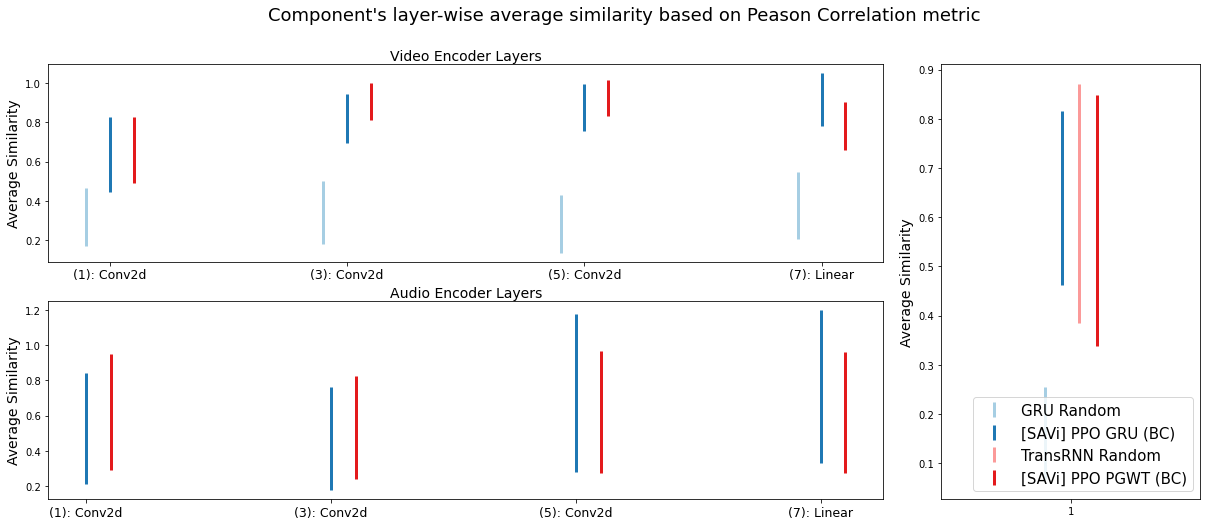

In [161]:
# Average similarities and Sparsities all in one
"""
    This expects:
        - PPO GRU Untrained (Random)
        - PPO PGWT Untrained (Random)
        - PPO GRU RL
        - PPO PGWT RL
"""
from turtle import position
from matplotlib.gridspec import GridSpec # TODO: move to the top

N_VARIANTS = len(VARIANT_RDMS_MEAN_STD.keys())
# VARIANTS_COLOR_PALETTE = sns.color_palette(n_colors=N_VARIANTS)
paired_color_palette = sns.color_palette("Paired")

VARIANTS_COLOR_PALETTE_DICT = {
    "ppo_gru__random": paired_color_palette[0], # Light blue
    "ppo_pgwt__random": paired_color_palette[4], # Light red
    
    # "ppo_gru__rl__SAVi": paired_color_palette[1], # Dark blue
    # "ppo_pgwt__rl__SAVi": paired_color_palette[5] # Dark red

    "ppo_gru__bc__SAVi": paired_color_palette[1], # Dark blue
    "ppo_pgwt__bc__SAVi": paired_color_palette[5] # Dark red
}
VARIANTS_BAR_SHIFTING = np.linspace(-0.1, 0.1, N_VARIANTS)[::-1]
VARIANTS_BAR_SHIFTING_1 = np.linspace(-0.1, 0.1, 3)[::-1] # For the visual and audio encoders

# VIS_AUD_VARIANTS_TO_PLOT = ["ppo_gru__random", "ppo_gru__rl__SAVi", "ppo_pgwt__rl__SAVi"]
VIS_AUD_VARIANTS_TO_PLOT = ["ppo_gru__random", "ppo_gru__bc__SAVi", "ppo_pgwt__bc__SAVi"]
VIS_AUD_VARIANTS_TO_PLOT_PALETTE = [VARIANTS_COLOR_PALETTE_DICT[k] for k in VIS_AUD_VARIANTS_TO_PLOT]

for dissm_metric, dissim_metric_data in RSA_DISSIM_METRICS.items():
    fig = plt.figure(figsize=(16,8))

    # Visual and audo encoder layers
    gs1 = GridSpec(2, 1, left=0.0, right=0.725, wspace=0)

    ## Video encoder layers
    vis_enc_ax = fig.add_subplot(gs1[0, 0])

    visual_encoder_layernames.sort()
    visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]
    x = np.arange(len(visual_encoder_layernames_relu_skipped)) # 2 PPO varaint per plot for each layer

    # for t, (agent_variant, agent_variant_drms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
    for t, agent_variant in enumerate(VIS_AUD_VARIANTS_TO_PLOT):
        agent_variant_drms_mean_std_dict = VARIANT_RDMS_MEAN_STD[agent_variant]
        # Skip plotting of the visual and audio encoder layers avg similarity plotting
        if agent_variant == "ppo_pgwt__random":
            continue
        y = [agent_variant_drms_mean_std_dict[lynm][dissm_metric]["mean"] for lynm in visual_encoder_layernames_relu_skipped]
        yerr = [agent_variant_drms_mean_std_dict[lynm][dissm_metric]["std"] for lynm in visual_encoder_layernames_relu_skipped]

        vis_enc_ax.errorbar(x-VARIANTS_BAR_SHIFTING_1[t], y, yerr, fmt="none",
                    elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE_DICT[agent_variant])

    vis_enc_ax.set_xlabel("Video Encoder Layers", fontsize=14)
    vis_enc_ax.xaxis.set_label_position("top")
    vis_enc_ax.set_ylabel("Average Similarity", fontsize=14)
    vis_enc_ax.set_xticks(x)
    visual_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]
    vis_enc_ax.set_xticklabels(visual_encoder_layernames_relu_skipped_pretty_names, fontsize=12.5)
    # vis_enc_ax.legend()

    ## Audo encoder layers
    aud_enc_ax = fig.add_subplot(gs1[1, 0])

    audio_encoder_layernames.sort()
    audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]

    x = np.arange(len(audio_encoder_layernames_relu_skipped)) # 2 PPO varaint per plot for each layer

    # for t, (agent_variant, agent_varaint_rdms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
    for t, agent_variant in enumerate(VIS_AUD_VARIANTS_TO_PLOT):
        agent_variant_drms_mean_std_dict = VARIANT_RDMS_MEAN_STD[agent_variant]
        # Skip plotting of the visual and audio encoder layers avg similarity plotting
        if agent_variant == "ppo_pgwt__random":
            continue
        y = [agent_variant_drms_mean_std_dict[lynm][dissm_metric]["mean"] for lynm in audio_encoder_layernames_relu_skipped]
        yerr = [agent_variant_drms_mean_std_dict[lynm][dissm_metric]["std"] for lynm in audio_encoder_layernames_relu_skipped]

        aud_enc_ax.errorbar(x-VARIANTS_BAR_SHIFTING_1[t], y, yerr, fmt="none",
                    elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE_DICT[agent_variant])

    aud_enc_ax.set_xlabel("Audio Encoder Layers", fontsize=14)
    aud_enc_ax.xaxis.set_label_position("top")
    aud_enc_ax.set_ylabel("Average Similarity", fontsize=14)
    aud_enc_ax.set_xticks(x)
    audio_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]
    aud_enc_ax.set_xticklabels(audio_encoder_layernames_relu_skipped_pretty_names, fontsize=12.5)
    # aud_enc_ax.legend()

    # State features plot
    gs2 = GridSpec(1,1, left=0.775, right=1.0, wspace=0.05)

    state_feat_ax = fig.add_subplot(gs2[0, 0])

    # for t, (agent_variant, agent_varaint_rdms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
    # for t, agent_variant in enumerate(["ppo_gru__random", "ppo_gru__rl__SAVi", "ppo_pgwt__random", "ppo_pgwt__rl__SAVi"]):
    for t, agent_variant in enumerate(["ppo_gru__random", "ppo_gru__bc__SAVi", "ppo_pgwt__random", "ppo_pgwt__bc__SAVi"]):
        agent_varaint_rdms_mean_std_dict = VARIANT_RDMS_MEAN_STD[agent_variant]
        y = agent_varaint_rdms_mean_std_dict["state_encoder"][dissm_metric]["mean"]
        yerr = agent_varaint_rdms_mean_std_dict["state_encoder"][dissm_metric]["std"]

        state_feat_ax.errorbar(1-VARIANTS_BAR_SHIFTING[t], y, yerr, fmt="none",
                    elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE_DICT[agent_variant])

    state_feat_ax.set_ylabel("Average Similarity", fontsize=14)
    # state_feat_ax.set_ylim(-0.1, 1)
    state_feat_ax.set_xticks([1])
    state_feat_ax.set_xlim(0.5, 1.5)
    state_feat_ax.legend(fontsize=15, loc="lower right")

    fig.suptitle(f"Component's layer-wise average similarity based on {dissim_metric_data['pretty_name']} metric", fontsize=18)
    # fig.tight_layout()
    fig.show()

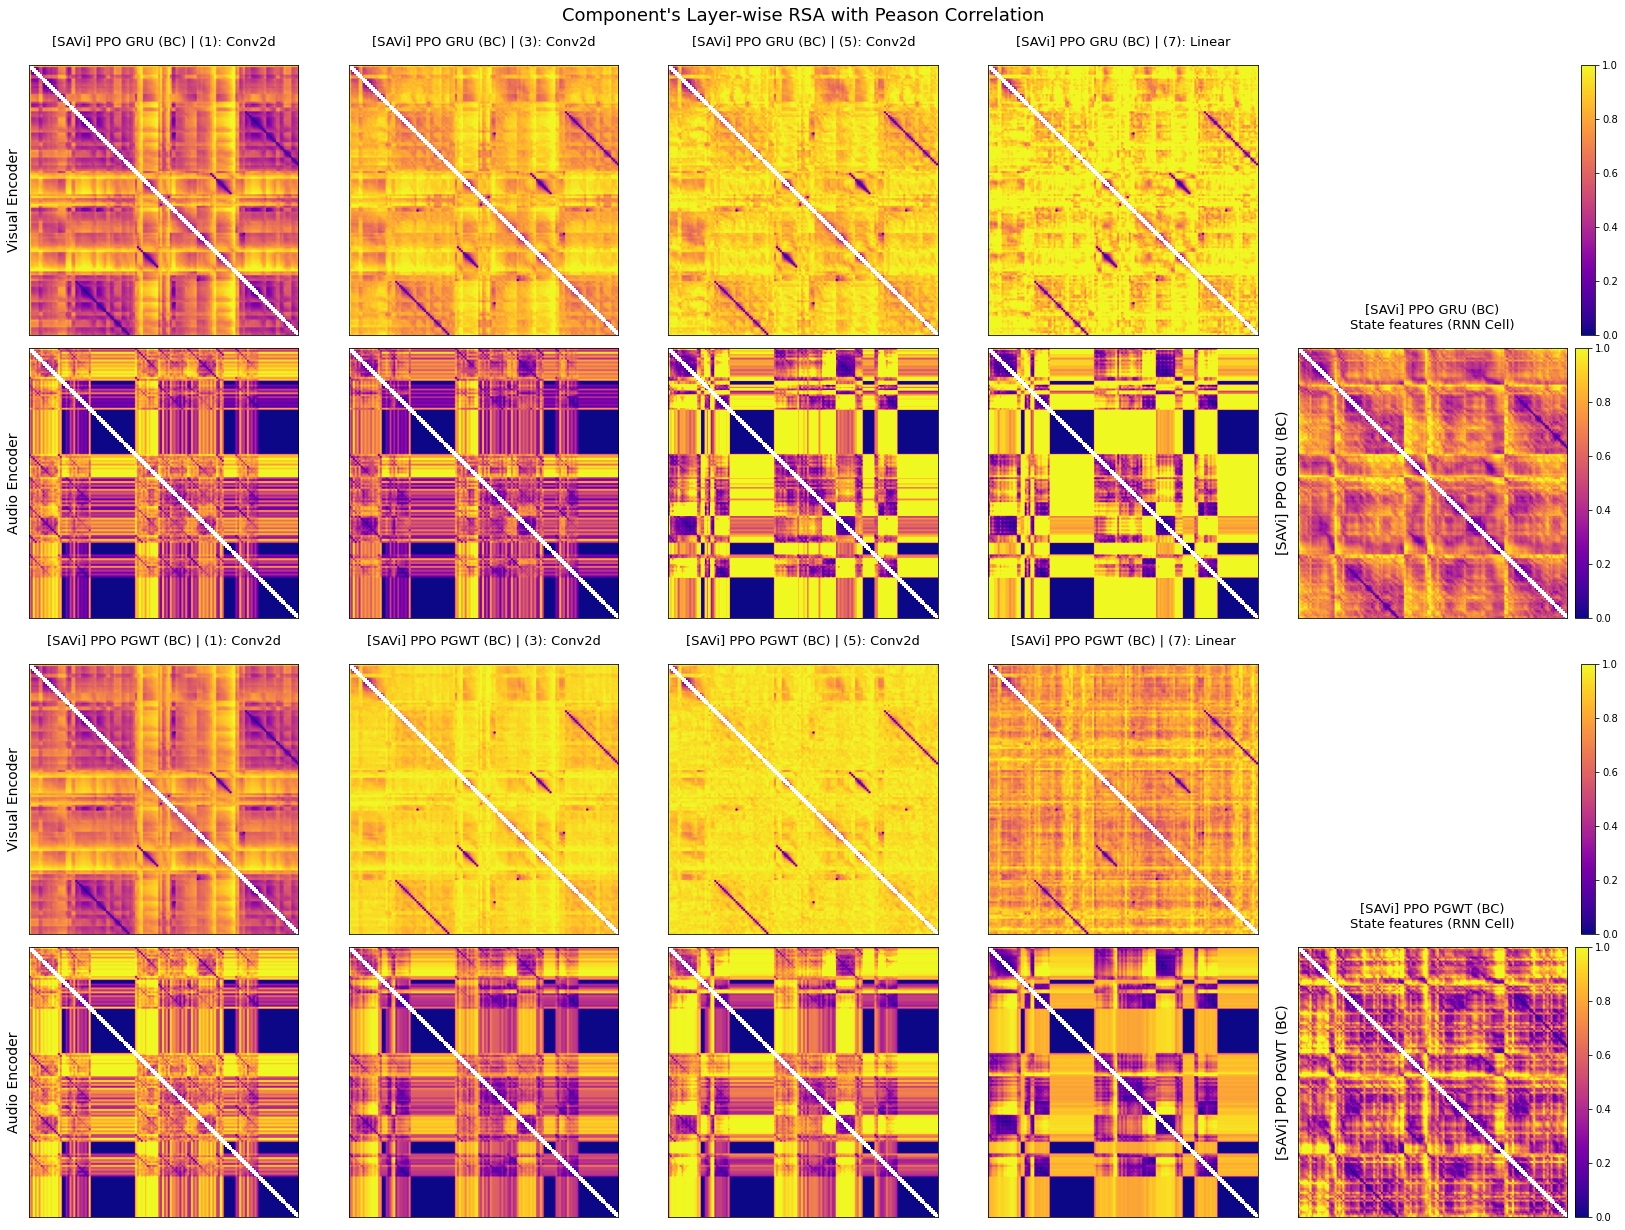

In [162]:
# All in one Plotn Style 2 Group by variant

## General

VARIANTS_TO_PLOT = [
    # RL variants
    # "ppo_gru__rl__SAVi",
    # "ppo_pgwt__rl__SAVi",

    # BC variants
    "ppo_gru__bc__SAVi",
    "ppo_pgwt__bc__SAVi",

    # Random
    # "ppo_gru__random",
    # "ppo_pgwt__random",
]
VARIANTS_RMDS_TO_PLOT = {k: VARIANTS_RDMS[k] for k in VARIANTS_TO_PLOT}

N_VARIANTS = len(VARIANTS_TO_PLOT)
assert N_VARIANTS == 2, f"Plot not supported with more than 2 agent variants for now."
for dissm_metric, dissim_metric_data in RSA_DISSIM_METRICS.items():
    
    # THe overall figure
    fig = plt.figure(figsize=(22,16))

    n_rows, n_cols = N_VARIANTS, len(visual_encoder_layernames_relu_skipped) + 1
    # n_rows, n_cols = N_VARIANTS, len(audio_encoder_layernames_relu_skipped)

    # One grid spec for each variant
    # TODO: this could be made even more systematic, so that a signle figure can have 
    # more than 2 agent variants
    gs1 = GridSpec(2, n_cols, left=0.0, right=1.0, top=1.0, bottom=0.52, wspace=0.05, hspace=0.05)
    gs2 = GridSpec(2, n_cols, left=0.0, right=1.0, top=0.48, bottom=0.0, wspace=0.05, hspace=0.05)
    # gs3 = GridSpec(n_rows, n_cols, left=0.765, right=0.95, top=0.75, bottom=0.25, wspace=0) # State features

    variant1_axes = [[fig.add_subplot(gs1[i, j]) for j in range(n_cols)] for i in range(2)] # 2 rows, one for visual enc. the other for audio enc.
    variant1_dividers = [make_axes_locatable(row_ax[-1]) for row_ax in variant1_axes]
    variant1_caxes = [ d.append_axes('right', size='5%', pad=0.1) for d in variant1_dividers]

    variant2_axes = [[fig.add_subplot(gs2[i, j]) for j in range(n_cols)] for i in range(2)]
    variant2_dividers = [make_axes_locatable(row_ax[-1]) for row_ax in variant2_axes]
    variant2_caxes = [ d.append_axes('right', size='5%', pad=0.1) for d in variant2_dividers]

    variants_axes = [variant1_axes, variant2_axes]
    variants_caxes = [variant1_caxes, variant2_caxes]

    ## Visual encoder
    visual_encoder_layernames.sort()
    visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]
    visual_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]

    ## Audio encoder
    audio_encoder_layernames.sort()
    audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]
    audio_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]

    # VMIN, VMAX = None, None
    VMIN, VMAX = 0, 1

    for variant_idx, (agent_variant, agent_variant_rdm) in enumerate(VARIANTS_RMDS_TO_PLOT.items()):
        agent_variant_pretty = MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"]

        # Plotting visual encoder RSA
        for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
            im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variants_axes[variant_idx][0][ax_idx],
                                        cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
            fig.colorbar(im, cax=variants_caxes[variant_idx][0], orientation='vertical')

            variants_axes[variant_idx][0][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=14)
            variants_axes[variant_idx][0][0].set_ylabel("Visual Encoder", fontsize=14)

            variants_axes[variant_idx][0][ax_idx].set_xlabel(f"{agent_variant_pretty} | {visual_encoder_layernames_relu_skipped_pretty_names[ax_idx]}\n", fontsize=13)
            variants_axes[variant_idx][0][ax_idx].xaxis.set_label_position("top")
        
        # Plotting audio encoder RSA
        for ax_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
            im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variants_axes[variant_idx][1][ax_idx],
                                        cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
            fig.colorbar(im, cax=variants_caxes[variant_idx][1], orientation='vertical')

            variants_axes[variant_idx][1][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=14)
            variants_axes[variant_idx][1][0].set_ylabel("Audio Encoder", fontsize=14)
            
            # TODO: requires a bit more margin to not overlap with the RSA plots
            # For now, since visual and audio encoder are more or less the same, just adding the text for the visual encoder row: 0
            # variants_axes[variant_idx][1][ax_idx].set_xlabel(f"{agent_variant_pretty} | {audio_encoder_layernames_relu_skipped_pretty_names[ax_idx]}\n", fontsize=13)
            # variants_axes[variant_idx][1][ax_idx].xaxis.set_label_position("top")

        # Plotting state features RSA
        im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm["state_encoder"][dissm_metric], ax=variants_axes[variant_idx][1][-1],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
        variants_axes[variant_idx][0][-1].remove()
        # TODO: also remove the redundant colorbar

        variants_axes[variant_idx][1][-1].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=14)
            
        variants_axes[variant_idx][1][-1].set_xlabel(f"{agent_variant_pretty}\nState features (RNN Cell)\n", fontsize=13, position="above")
        variants_axes[variant_idx][1][-1].xaxis.set_label_position("top")

    # TODO: position this on top better
    fig.suptitle(f"Component's Layer-wise RSA with {dissim_metric_data['pretty_name']}", fontsize=18, y=1.05)
    # fig.tight_layout()
    fig.show()

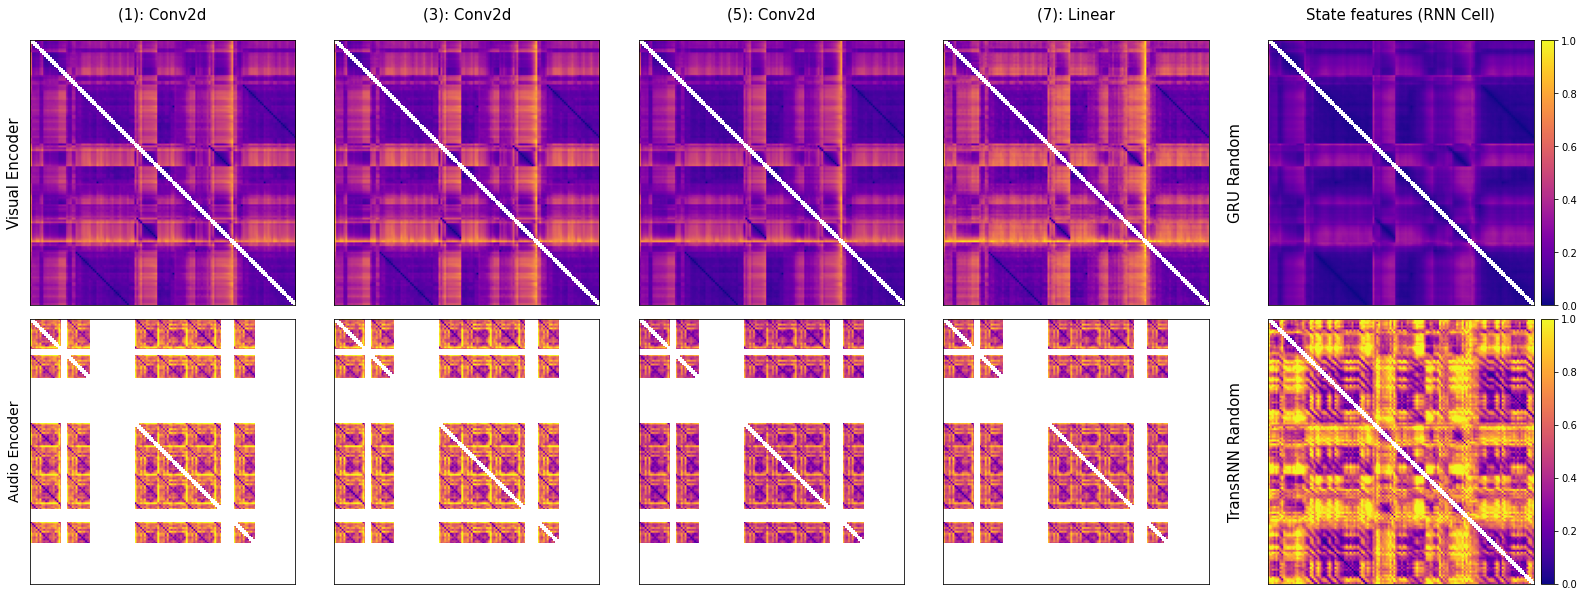

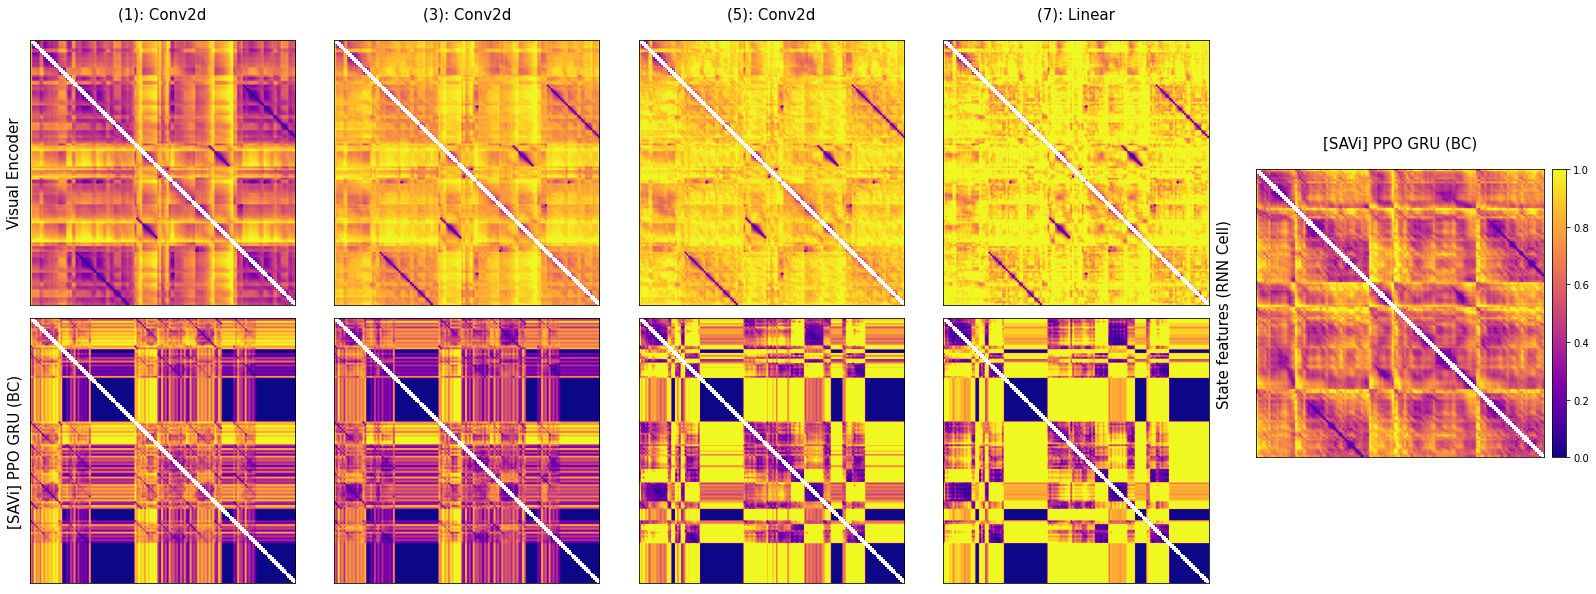

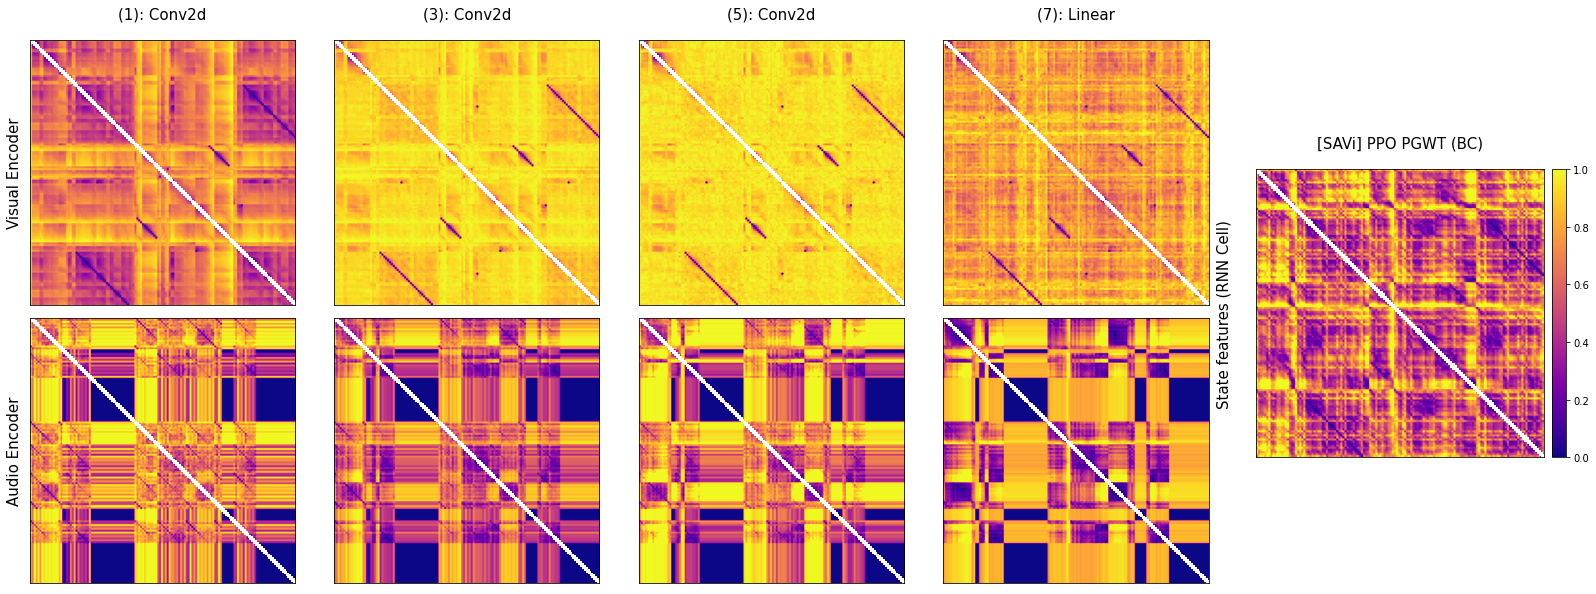

In [163]:
# All in one Plotn Style 3 Group by variant

## General

VARIANTS_TO_PLOT = [
    # BC variants
    "ppo_gru__bc__SAVi",
    "ppo_pgwt__bc__SAVi",

    # Random
    "ppo_gru__random",
    "ppo_pgwt__random",

    # # RL variants
    # "ppo_gru__rl__SAVi",
    # "ppo_pgwt__rl__SAVi",

]
VARIANTS_RMDS_TO_PLOT = {k: VARIANTS_RDMS[k] for k in VARIANTS_TO_PLOT}

N_VARIANTS = len(VARIANTS_TO_PLOT)
## Visual encoder
visual_encoder_layernames.sort()
visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]
visual_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]

## Audio encoder
audio_encoder_layernames.sort()
audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]
audio_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]

for dissm_metric, dissim_metric_data in RSA_DISSIM_METRICS.items():
    
    # THe overall figure
    fig = plt.figure(figsize=(22,10))

    n_rows, n_cols = N_VARIANTS, len(visual_encoder_layernames_relu_skipped)

    # One gridspec for "randomly inited variants", "PPO GRU RL SAVi" and "PPO PGWT RL SAVi"
    ## For Random variants
    gs0_left = GridSpec(2, n_cols, left=0.0, right=0.76, wspace=0.05, hspace=0.05)
    gs0_right = GridSpec(2, 1, left=0.78, right=0.98, wspace=0.05, hspace=0.05)
    
    variant0_left_axes = [[fig.add_subplot(gs0_left[i, j]) for j in range(n_cols)] for i in range(2)]
    variant0_right_axes = [[fig.add_subplot(gs0_right[i, j]) for j in range(1)] for i in range(2)]

    variant0_right_dividers = [make_axes_locatable(row_ax[-1]) for row_ax in variant0_right_axes]
    variant0_right_caxes = [d.append_axes('right', size='5%', pad=0.1) for d in variant0_right_dividers]

    # VMIN, VMAX = None, None
    VMIN, VMAX = 0, 1
    
    for variant_idx, agent_variant in enumerate(["ppo_gru__random", "ppo_pgwt__random"]):
        agent_variant_rdm = VARIANTS_RDMS[agent_variant]
        agent_variant_pretty = MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"]

        if variant_idx == 0:
            # Plotting visual encoder RSA
            for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[0][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[0][0], orientation='vertical')

                variant0_left_axes[0][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                variant0_left_axes[0][0].set_ylabel("Visual Encoder", fontsize=15)

                variant0_left_axes[0][ax_idx].set_xlabel(f"{visual_encoder_layernames_relu_skipped_pretty_names[ax_idx]}\n", fontsize=15)
                variant0_left_axes[0][ax_idx].xaxis.set_label_position("top")

            # Plotting audio encoder RSA
            for ax_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[1][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[1][0], orientation='vertical')

                variant0_left_axes[1][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                variant0_left_axes[1][0].set_ylabel("Audio Encoder", fontsize=14)
        
        # Plotting state features RSA
        im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm["state_encoder"][dissm_metric], ax=variant0_right_axes[variant_idx][-1],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)

        variant0_right_axes[variant_idx][-1].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
        
        variant0_right_axes[variant_idx][-1].set_ylabel(f"{agent_variant_pretty}\n", fontsize=15)
        fig.colorbar(im, cax=variant0_right_caxes[variant_idx], orientation='vertical')
        if variant_idx == 0:
            variant0_right_axes[variant_idx][-1].set_xlabel(f"State features (RNN Cell)\n", fontsize=15, position="above")
            variant0_right_axes[variant_idx][-1].xaxis.set_label_position("top")

    # fig.suptitle(f"Component's Layer-wise RSA with {dissim_metric_data['pretty_name']}", fontsize=18, y=1)
    # fig.tight_layout()
    fig.show()

    ## PPO GRU RL (SAVi)

    # THe overall figure
    fig = plt.figure(figsize=(22,10))

    n_rows, n_cols = N_VARIANTS, len(visual_encoder_layernames_relu_skipped)

    # One gridspec for "randomly inited variants", "PPO GRU RL SAVi" and "PPO PGWT RL SAVi"
    ## For Random variants
    gs0_left = GridSpec(2, n_cols, left=0.0, right=0.76, wspace=0.05, hspace=0.05)
    gs0_right = GridSpec(1, 1, left=0.78, right=0.98, top=0.70, bottom=0.30, wspace=0.05, hspace=0.05)
    
    variant0_left_axes = [[fig.add_subplot(gs0_left[i, j]) for j in range(n_cols)] for i in range(2)]
    variant0_right_axes = [[fig.add_subplot(gs0_right[i, j]) for j in range(1)] for i in range(1)]

    variant0_right_dividers = [make_axes_locatable(row_ax[-1]) for row_ax in variant0_right_axes]
    variant0_right_caxes = [d.append_axes('right', size='5%', pad=0.1) for d in variant0_right_dividers]

    for variant_idx, agent_variant in enumerate(["ppo_gru__bc__SAVi"]):
        agent_variant_rdm = VARIANTS_RDMS[agent_variant]
        agent_variant_pretty = MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"]

        if variant_idx == 0:
            # Plotting visual encoder RSA
            for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[0][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[0][0], orientation='vertical')

                variant0_left_axes[0][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                variant0_left_axes[0][0].set_ylabel("Visual Encoder", fontsize=15)

                variant0_left_axes[0][ax_idx].set_xlabel(f"{visual_encoder_layernames_relu_skipped_pretty_names[ax_idx]}\n", fontsize=15)
                variant0_left_axes[0][ax_idx].xaxis.set_label_position("top")

            # Plotting audio encoder RSA
            for ax_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[1][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[1][0], orientation='vertical')

                variant0_left_axes[1][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                # variant0_left_axes[1][0].set_ylabel("Audio Encoder", fontsize=15)
        
        # Plotting state features RSA
        im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm["state_encoder"][dissm_metric], ax=variant0_right_axes[variant_idx][-1],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)

        variant0_right_axes[variant_idx][-1].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
        
        variant0_right_axes[variant_idx][-1].set_xlabel(f"{agent_variant_pretty}\n", fontsize=15)
        variant0_right_axes[variant_idx][-1].xaxis.set_label_position("top")
        variant0_right_axes[variant_idx][-1].set_ylabel(f"State features (RNN Cell)\n", fontsize=15, position="above")
        fig.colorbar(im, cax=variant0_right_caxes[variant_idx], orientation='vertical')

    ## PPO PGWT RL (SAVi)

    # THe overall figure
    fig = plt.figure(figsize=(22,10))

    n_rows, n_cols = N_VARIANTS, len(visual_encoder_layernames_relu_skipped)

    # One gridspec for "randomly inited variants", "PPO GRU RL SAVi" and "PPO PGWT RL SAVi"
    ## For Random variants
    gs0_left = GridSpec(2, n_cols, left=0.0, right=0.76, wspace=0.05, hspace=0.05)
    gs0_right = GridSpec(1, 1, left=0.78, right=0.98, top=0.70, bottom=0.30, wspace=0.05, hspace=0.05)
    
    variant0_left_axes = [[fig.add_subplot(gs0_left[i, j]) for j in range(n_cols)] for i in range(2)]
    variant0_right_axes = [[fig.add_subplot(gs0_right[i, j]) for j in range(1)] for i in range(1)]

    variant0_right_dividers = [make_axes_locatable(row_ax[-1]) for row_ax in variant0_right_axes]
    variant0_right_caxes = [d.append_axes('right', size='5%', pad=0.1) for d in variant0_right_dividers]

    for variant_idx, agent_variant in enumerate(["ppo_pgwt__bc__SAVi"]):
        agent_variant_rdm = VARIANTS_RDMS[agent_variant]
        agent_variant_pretty = MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"]

        if variant_idx == 0:
            # Plotting visual encoder RSA
            for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[0][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[0][0], orientation='vertical')

                variant0_left_axes[0][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                variant0_left_axes[0][0].set_ylabel("Visual Encoder", fontsize=15)

                variant0_left_axes[0][ax_idx].set_xlabel(f"{visual_encoder_layernames_relu_skipped_pretty_names[ax_idx]}\n", fontsize=15)
                variant0_left_axes[0][ax_idx].xaxis.set_label_position("top")

            # Plotting audio encoder RSA
            for ax_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[1][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[1][0], orientation='vertical')

                variant0_left_axes[1][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                variant0_left_axes[1][0].set_ylabel("Audio Encoder", fontsize=15)
        
        # Plotting state features RSA
        im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm["state_encoder"][dissm_metric], ax=variant0_right_axes[variant_idx][-1],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)

        variant0_right_axes[variant_idx][-1].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
        
        variant0_right_axes[variant_idx][-1].set_xlabel(f"{agent_variant_pretty}\n", fontsize=15)
        variant0_right_axes[variant_idx][-1].xaxis.set_label_position("top")
        variant0_right_axes[variant_idx][-1].set_ylabel(f"State features (RNN Cell)\n", fontsize=15, position="above")
        fig.colorbar(im, cax=variant0_right_caxes[variant_idx], orientation='vertical')
    
    fig.show()

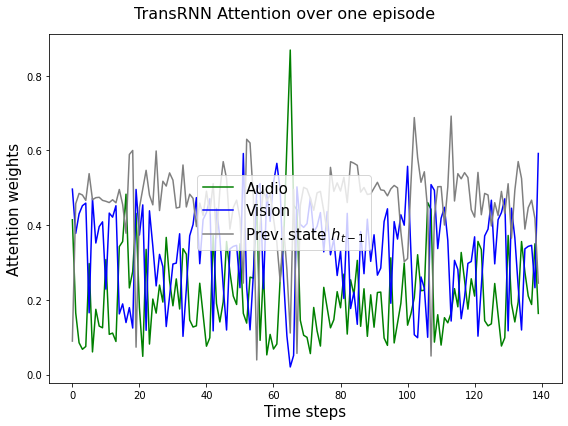

In [164]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(8,6))
ep_length = AGENT_FEATURES["ppo_pgwt__bc__SAVi"]["state_encoder.ca.mha"][1].shape[0]
x = np.arange(ep_length)

MOD_AXIS_TO_NAME = {0: "Audio", 1: "Vision", 2: r"Prev. state $h_{t-1}$" }
MOD_AXIS_TO_COLOR = { 0: "green", 1: "blue", 2: "grey" }

for mod_axis in range(3):
    ax.plot(x, AGENT_FEATURES["ppo_pgwt__bc__SAVi"]["state_encoder.ca.mha"][1].mean(1)[:, mod_axis],
            label=MOD_AXIS_TO_NAME[mod_axis],
            color=MOD_AXIS_TO_COLOR[mod_axis])

ax.set_ylabel("Attention weights", fontsize=15)
ax.set_xlabel("Time steps", fontsize=15)
fig.legend(fontsize=15, loc="center")
fig.suptitle("TransRNN Attention over one episode", fontsize=16)
fig.tight_layout()
fig.show()
